In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load and prepare your data
df = pd.read_csv("dataset/T1.csv", parse_dates=['Date/Time'])

# Now convert to datetime with dayfirst=True (since your format is day month year)
df['Date/Time'] = pd.to_datetime(df['Date/Time'], dayfirst=True)
df = df.sort_values('Date/Time')

# Calculate time_diff first
df['time_diff'] = df['Date/Time'].diff().dt.total_seconds().div(60)
df['time_diff'].fillna(0, inplace=True)  # Handle first row NaN

features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)', 'time_diff']
target = 'LV ActivePower (kW)'
X, y = df[features], df[target]

In [4]:
# Define pipeline
mlp = MLPRegressor(random_state=42, max_iter=500)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])

# Define search space
param_distributions = {
    'mlp__hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': np.logspace(-5, -2, 4),
    'mlp__learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
    'mlp__batch_size': [32, 64, 128],
    'mlp__early_stopping': [True]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=25,                 # reasonable for Colab
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X, y)

# Best model
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

# Evaluate on final hold-out test set
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'mlp__solver': 'adam', 'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__early_stopping': True, 'mlp__batch_size': 64, 'mlp__alpha': 1e-05, 'mlp__activation': 'tanh'}
Test MAE: 214.98, RMSE: 409.22, R²: 0.9070


In [ ]:
# this

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Example train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline: Polynomial Features + Scaling + Ridge Regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define parameter grid
param_grid = {
    'poly__degree': [1, 2, 3],
    'ridge__alpha': np.logspace(-3, 2, 6)
}

# Grid search with 5-fold cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# Best parameters and results
print("Best parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

# Evaluate on test set
y_pred = grid.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)  # Using root_mean_squared_error instead
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'poly__degree': 1, 'ridge__alpha': 0.001}
Best CV R²: 0.9066797199044172
Test MAE: 188.73, RMSE: 411.28, R²: 0.9009


In [ ]:
# this 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------
# 1. Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Function for model evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

results = {}

# ----------------------------
# 2. LASSO REGRESSION
# ----------------------------
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

lasso_params = {
    'lasso__alpha': np.logspace(-4, 1, 10)
}

lasso_grid = GridSearchCV(lasso_pipe, lasso_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
lasso_grid.fit(X_train, y_train)

mae, rmse, r2 = evaluate_model(lasso_grid, X_test, y_test)
results['Lasso Regression'] = {
    'Best Params': lasso_grid.best_params_,
    'MAE': mae, 'RMSE': rmse, 'R²': r2
}

# ----------------------------
# 3. ELASTICNET REGRESSION
# ----------------------------
elastic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(max_iter=10000))
])

elastic_params = {
    'elastic__alpha': np.logspace(-4, 1, 10),
    'elastic__l1_ratio': np.linspace(0.1, 0.9, 5)
}

elastic_grid = GridSearchCV(elastic_pipe, elastic_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
elastic_grid.fit(X_train, y_train)

mae, rmse, r2 = evaluate_model(elastic_grid, X_test, y_test)
results['ElasticNet Regression'] = {
    'Best Params': elastic_grid.best_params_,
    'MAE': mae, 'RMSE': rmse, 'R²': r2
}

# ----------------------------
# 4. POLYNOMIAL RIDGE REGRESSION
# ----------------------------
poly_ridge_pipe = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

poly_ridge_params = {
    'poly__degree': [1, 2, 3],
    'ridge__alpha': np.logspace(-3, 2, 6)
}

poly_ridge_grid = GridSearchCV(poly_ridge_pipe, poly_ridge_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
poly_ridge_grid.fit(X_train, y_train)

mae, rmse, r2 = evaluate_model(poly_ridge_grid, X_test, y_test)
results['Polynomial Ridge Regression'] = {
    'Best Params': poly_ridge_grid.best_params_,
    'MAE': mae, 'RMSE': rmse, 'R²': r2
}

# ----------------------------
# 5. DISPLAY RESULTS
# ----------------------------
results_df = pd.DataFrame(results).T
results_df = results_df[['Best Params', 'MAE', 'RMSE', 'R²']]
print("\n===== Model Comparison Results =====")
print(results_df)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fitting 5 folds for each of 18 candidates, totalling 90 fits

===== Model Comparison Results =====
                                                                   Best Params  \
Lasso Regression                          {'lasso__alpha': 0.7742636826811278}   
ElasticNet Regression        {'elastic__alpha': 0.0001, 'elastic__l1_ratio'...   
Polynomial Ridge Regression         {'poly__degree': 1, 'ridge__alpha': 0.001}   

                                    MAE        RMSE        R²  
Lasso Regression             188.679136  411.302678  0.900856  
ElasticNet Regression        188.730903  411.282855  0.900866  
Polynomial Ridge Regression  188.727479  411.282785  0.900866  


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# -----------------------------
# From here evaliation starts
# -----------------------------

In [10]:
# Evaluation Toolkit (drop into your notebook)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.tsa.stattools import acf

sns.set_theme(style='whitegrid')

In [ ]:
# ---------------------------
# Helper metrics
# ---------------------------
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    safe = denom == 0
    res = np.abs(y_pred - y_true) / np.where(safe, 1.0, denom)
    res[safe] = 0.0
    return np.mean(res) * 100

def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    sm = smape(y_true, y_pred)
    errs = np.abs(y_true - y_pred)
    percentiles = np.percentile(errs, [50, 75, 90, 95])
    return {
        "MAE": mae, "RMSE": rmse, "R2": r2, "MedAE": medae, "SMAPE(%)": sm,
        "Err_p50": percentiles[0], "Err_p75": percentiles[1], "Err_p90": percentiles[2], "Err_p95": percentiles[3]
    }

# ---------------------------
# Block bootstrap (time-series aware)
# ---------------------------
def block_bootstrap_metric_ci(y_true, y_pred, metric_func, block_size=24, n_boot=1000, alpha=0.05, random_state=42):
    """
    Compute block-bootstrap CI for given metric_func(y_true, y_pred).
    block_size in number of time steps (e.g., 24 for ~4 hours at 10-min intervals).
    """
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    # Build block indices
    blocks = []
    for start in range(0, n, block_size):
        end = min(n, start + block_size)
        blocks.append(np.arange(start, end))
    n_blocks = len(blocks)
    k = int(np.ceil(n / block_size))
    vals = []
    for _ in range(n_boot):
        chosen = rng.choice(n_blocks, size=k, replace=True)
        idx = np.concatenate([blocks[c] for c in chosen])[:n]
        vals.append(metric_func(y_true[idx], y_pred[idx]))
    vals = np.array(vals)
    lower = np.percentile(vals, 100 * alpha/2.)
    upper = np.percentile(vals, 100 * (1 - alpha/2.))
    orig = metric_func(y_true, y_pred)
    return orig, lower, upper, vals

# ---------------------------
# Paired tests (Wilcoxon, paired t)
# ---------------------------
def paired_tests_time_series(y_true, pred_a, pred_b, loss='abs'):
    """
    Returns paired t-test and Wilcoxon on per-sample loss difference.
    loss: 'abs' or 'sq'.
    """
    y_true = np.asarray(y_true)
    pred_a = np.asarray(pred_a); pred_b = np.asarray(pred_b)
    if loss == 'abs':
        e_a = np.abs(y_true - pred_a)
        e_b = np.abs(y_true - pred_b)
    else:
        e_a = (y_true - pred_a)**2
        e_b = (y_true - pred_b)**2
    # Paired t-test
    t_stat, t_p = ttest_rel(e_a, e_b, nan_policy='omit')
    # Wilcoxon
    try:
        w_stat, w_p = wilcoxon(e_a, e_b)
    except Exception:
        w_stat, w_p = np.nan, np.nan
    return {"t_stat": t_stat, "t_p": t_p, "wilcoxon_stat": w_stat, "wilcoxon_p": w_p, "mean_diff": np.mean(e_a - e_b)}

# ---------------------------
# Block-bootstrap p-value for difference in losses
# ---------------------------
def block_bootstrap_pvalue(y_true, pred_a, pred_b, block_size=24, n_boot=2000, loss='abs', alternative='two-sided', random_state=42):
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true); pred_a = np.asarray(pred_a); pred_b = np.asarray(pred_b)
    n = len(y_true)
    if loss == 'abs':
        d = np.abs(y_true - pred_a) - np.abs(y_true - pred_b)
    else:
        d = (y_true - pred_a)**2 - (y_true - pred_b)**2
    obs = np.mean(d)
    # blocks
    blocks = []
    for start in range(0, n, block_size):
        end = min(n, start + block_size)
        blocks.append(np.arange(start, end))
    n_blocks = len(blocks)
    k = int(np.ceil(n / block_size))
    boot_means = []
    for _ in range(n_boot):
        chosen = rng.choice(n_blocks, size=k, replace=True)
        idx = np.concatenate([blocks[c] for c in chosen])[:n]
        boot_means.append(np.mean(d[idx]))
    boot_means = np.array(boot_means)
    if alternative == 'two-sided':
        pval = np.mean(np.abs(boot_means) >= np.abs(obs))
    elif alternative == 'greater':
        pval = np.mean(boot_means >= obs)
    else:
        pval = np.mean(boot_means <= obs)
    return {"obs_mean": obs, "p_value": pval, "boot_means": boot_means}

# ---------------------------
# Residual ACF to choose block length
# ---------------------------
def suggest_block_length(residuals, threshold=0.2, nlags=200):
    """
    Returns first lag where ACF < threshold. residuals is 1D array.
    """
    acfs = acf(residuals, nlags=nlags, fft=True, missing='conservative')
    # skip lag 0
    for lag in range(1, len(acfs)):
        if np.abs(acfs[lag]) < threshold:
            return lag
    return int(np.where(np.abs(acfs) < threshold)[0][0]) if np.any(np.abs(acfs) < threshold) else nlags

# ---------------------------
# Plotting utilities
# ---------------------------
def plot_pred_vs_actual(y_true, y_pred, title='Predicted vs Actual', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.3, s=10, ax=ax)
    mn = min(np.min(y_true), np.min(y_pred)); mx = max(np.max(y_true), np.max(y_pred))
    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
    ax.set_xlabel('Actual (kW)'); ax.set_ylabel('Predicted (kW)'); ax.set_title(title)
    return ax

def plot_time_series_compare(dates, y_true, y_pred, n_show=2000, title='Time series: Actual vs Predicted'):
    # plot last n_show points
    idx = np.arange(len(y_true))[-n_show:]
    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(dates.iloc[idx], y_true.iloc[idx], label='Actual', alpha=0.8)
    ax.plot(dates.iloc[idx], y_pred.iloc[idx], label='Predicted', alpha=0.8)
    ax.legend(); plt.xticks(rotation=30); ax.set_title(title)
    return ax

def plot_residuals_hist(y_true, y_pred, bins=50):
    resid = np.asarray(y_true) - np.asarray(y_pred)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(resid, bins=bins, kde=True, ax=ax)
    ax.set_title('Residuals distribution'); ax.set_xlabel('Residual (Actual - Predicted) (kW)')
    return ax

def plot_residuals_vs_pred(y_true, y_pred):
    resid = np.asarray(y_true) - np.asarray(y_pred)
    fig, ax = plt.subplots(figsize=(6,4))
    sns.scatterplot(x=y_pred, y=resid, s=8, alpha=0.3, ax=ax)
    ax.axhline(0, color='r', linestyle='--'); ax.set_xlabel('Predicted (kW)'); ax.set_ylabel('Residual (kW)')
    ax.set_title('Residuals vs Predicted')
    return ax

def plot_qq(y_true, y_pred):
    resid = np.asarray(y_true) - np.asarray(y_pred)
    fig, ax = plt.subplots(figsize=(6,4))
    stats.probplot(resid, dist='norm', plot=ax)
    ax.set_title('QQ-plot of residuals')
    return ax

def plot_error_by_bin(test_df, feature_col, y_true_col, y_pred_col, bins=6, kind='bar'):
    tmp = test_df.copy()
    tmp['_abs_err'] = np.abs(tmp[y_true_col] - tmp[y_pred_col])
    tmp['_bin'] = pd.cut(tmp[feature_col], bins=bins)
    agg = tmp.groupby('_bin')['_abs_err'].agg(['mean','median','count']).reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    agg['mean'].plot(kind='bar', ax=ax)
    ax.set_title(f'Mean absolute error by {feature_col} bins'); ax.set_ylabel('MAE (kW)')
    plt.xticks(rotation=45)
    return ax, agg

# ---------------------------
# Top-N error cases
# ---------------------------
def show_top_n_errors(test_df, y_true_col, y_pred_col, n=10, context=12):
    tmp = test_df.copy()
    tmp['_abs_err'] = np.abs(tmp[y_true_col] - tmp[y_pred_col])
    top = tmp.nlargest(n, '_abs_err')
    cases = []
    for idx in top.index:
        start = max(0, idx - context); end = min(len(tmp)-1, idx + context)
        cases.append(tmp.iloc[start:end+1])
    return cases

# ---------------------------
# Batch evaluation driver
# ---------------------------
def evaluate_all_models(y_test, preds, test_df=None, block_size=24, n_boot=1000):
    """
    preds: dict {model_name: y_pred_array}
    test_df: optional DataFrame aligned with y_test (columns: Date/Time, features)
    """
    # Compute metrics
    metrics = {}
    for name, y_pred in preds.items():
        metrics[name] = compute_metrics(y_test, y_pred)
    metrics_df = pd.DataFrame(metrics).T

    # Bootstrapped CI for MAE and RMSE using block-bootstrap
    cis = {}
    for name, y_pred in preds.items():
        mae, lower_mae, upper_mae, _ = block_bootstrap_metric_ci(y_test, y_pred,
                                                                 lambda yt, yp: mean_absolute_error(yt, yp),
                                                                 block_size=block_size, n_boot=n_boot)
        rmse, lower_rmse, upper_rmse, _ = block_bootstrap_metric_ci(y_test, y_pred,
                                                                    lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)),
                                                                    block_size=block_size, n_boot=n_boot)
        cis[name] = {'MAE_ci': (lower_mae, mae, upper_mae), 'RMSE_ci': (lower_rmse, rmse, upper_rmse)}
    cis_df = pd.DataFrame(cis).T

    # Choose best model by MAE
    best_name = metrics_df['MAE'].idxmin()
    best_preds = preds[best_name]

    # Paired tests & block bootstrap p-values vs best
    comparisons = {}
    for name, y_pred in preds.items():
        if name == best_name:
            comparisons[name] = {'paired_t_p': np.nan, 'wilcoxon_p': np.nan, 'block_p': np.nan}
            continue
        pt = paired_tests_time_series(y_test, preds[best_name], y_pred, loss='abs')
        bb = block_bootstrap_pvalue(y_test, preds[best_name], y_pred, block_size=block_size, n_boot=1000)
        comparisons[name] = {'paired_t_p': pt['t_p'], 'wilcoxon_p': pt['wilcoxon_p'], 'block_p': bb['p_value']}

    comparisons_df = pd.DataFrame(comparisons).T

    # Merge everything
    full = metrics_df.join(cis_df).join(comparisons_df)
    # If test_df given, append prediction series to test_df for plotting
    if test_df is not None:
        for name, y_pred in preds.items():
            test_df[f'pred_{name}'] = y_pred
    return full, test_df

# ---------------------------
# Learning curve (progressive training sizes)
# ---------------------------
def time_series_learning_curve_builder(build_model_fn, X_train, y_train, X_val, y_val, train_fracs=[0.2,0.4,0.6,0.8,1.0], metric_fn=mean_absolute_error):
    """
    build_model_fn() -> new untrained sklearn-like regressor with fit/predict.
    Returns dict with train_scores and val_scores per fraction.
    """
    n = len(X_train)
    train_scores = []
    val_scores = []
    for frac in train_fracs:
        n_tr = int(frac * n)
        if n_tr < 10:
            train_scores.append(np.nan); val_scores.append(np.nan); continue
        model = build_model_fn()
        model.fit(X_train.iloc[:n_tr], y_train.iloc[:n_tr])
        ytr = model.predict(X_train.iloc[:n_tr]); yv = model.predict(X_val)
        train_scores.append(metric_fn(y_train.iloc[:n_tr], ytr))
        val_scores.append(metric_fn(y_val, yv))
    return {'train_fracs': train_fracs, 'train_scores': train_scores, 'val_scores': val_scores}


In [ ]:
# =======================
# Linear Regression
# =======================
from sklearn.linear_model import LinearRegression

models = {
    "Linear Regression": LinearRegression(),
}

# =======================
# Cross-validation setup
# =======================
tscv = TimeSeriesSplit(n_splits=5)

results = []

for name, model in models.items():
    mae_list, rmse_list, r2_list = [], [], []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Build pipeline with scaling for linear models
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    results.append({
        "Model": name,
        "MAE": np.mean(mae_list),
        "RMSE": np.mean(rmse_list),
        "R²": np.mean(r2_list)
    })

# =======================
# Results summary
# =======================
results_df = pd.DataFrame(results)
print(results_df.sort_values("RMSE"))
y_pred_lin = y_pred

               Model         MAE        RMSE        R²
0  Linear Regression  210.769411  317.006411  0.934226


In [18]:
# =======================
# MLP and XGB
# =======================
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

models = {
    "XGBoost": XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        early_stopping_rounds=20,
        objective='reg:squarederror'
    ),
    "MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            learning_rate_init=0.001,
            max_iter=500,
            alpha=0.001,
            random_state=42
        ))
    ])
}

# =======================
# Evaluation
# =======================
tscv = TimeSeriesSplit(n_splits=5)
results = []

# Initialize variables to store predictions
y_pred_mlp_list = []
y_pred_xgb_list = []
y_test_list = []

for name, model in models.items():
    mae_list, rmse_list, r2_list = [], [], []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Handle different model parameters
        if name == "XGBoost":
            model.fit(X_train, y_train,
                     eval_set=[(X_test, y_test)],
                     verbose=False)
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        # Store predictions for the last fold (you can modify this logic as needed)
        if fold == 4:  # Store predictions from the last fold
            if name == "MLP":
                y_pred_mlp_list = y_pred
                y_test_mlp = y_test
            elif name == "XGBoost":
                y_pred_xgb_list = y_pred
                y_test_xgb = y_test
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    results.append({
        "Model": name,
        "MAE": np.mean(mae_list),
        "RMSE": np.mean(rmse_list),
        "R²": np.mean(r2_list)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")
print(results_df)

# Store the predictions from the last fold
y_pred_mlp = y_pred_mlp_list
y_pred_xgb = y_pred_xgb_list

print(f"Stored predictions: MLP shape {y_pred_mlp.shape}, XGBoost shape {y_pred_xgb.shape}")

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


     Model         MAE        RMSE        R²
1      MLP  188.090026  362.285659  0.913074
0  XGBoost  202.168336  374.800178  0.907761
Stored predictions: MLP shape (8421,), XGBoost shape (8421,)


                MAE        RMSE        R2       MedAE   SMAPE(%)     Err_p50  \
Linear   244.281148  448.719109  0.893128  129.902725  61.260083  129.902725   
MLP      268.384810  502.115748  0.866179  117.492607  62.798454  117.492607   
XGBoost  271.685662  495.445242  0.869711  131.090820  61.032175  131.090820   

            Err_p75     Err_p90      Err_p95  \
Linear   299.950030  439.748470   806.395948   
MLP      272.067618  712.212535  1270.411379   
XGBoost  287.067627  685.570801  1303.481781   

                                                    MAE_ci  \
Linear   (209.07231239375906, 244.28114817124504, 281.4...   
MLP      (228.01648577295168, 268.38481041492605, 307.5...   
XGBoost  (232.64359594328877, 271.6856620563327, 309.32...   

                                                   RMSE_ci    paired_t_p  \
Linear   (356.21471261966644, 448.7191093810085, 534.60...           NaN   
MLP      (425.9632801134878, 502.1157484438223, 572.773...  2.165204e-16   
XGBoost  

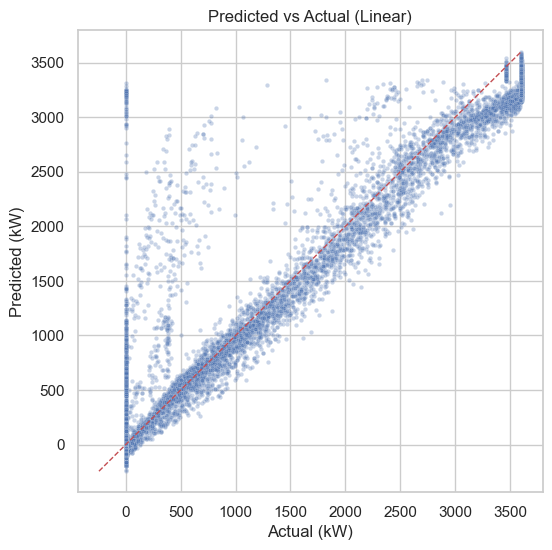

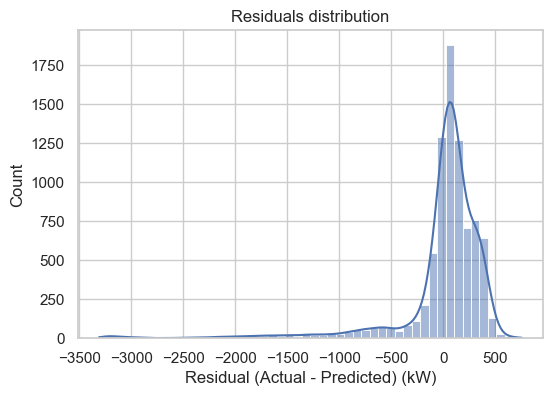

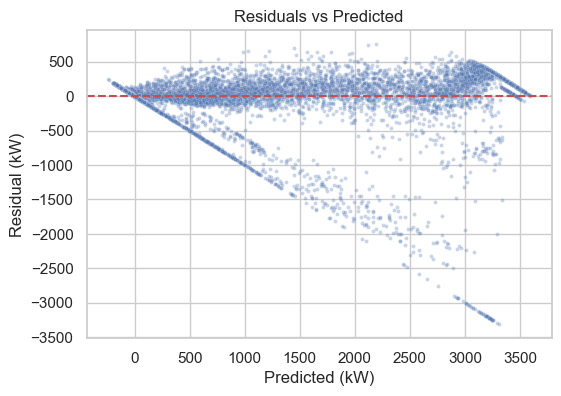

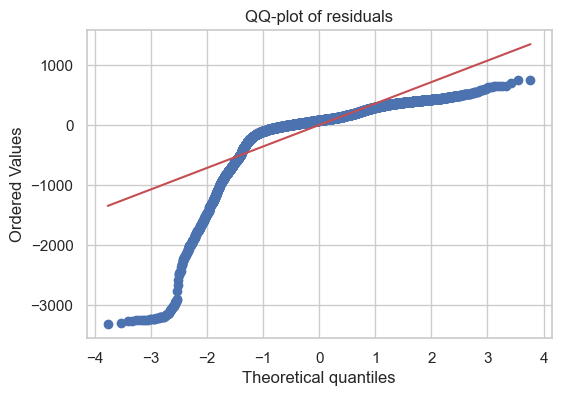

C:\Users\User\AppData\Local\Temp\ipykernel_23512\1452738904.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby('_bin')['_abs_err'].agg(['mean','median','count']).reset_index()


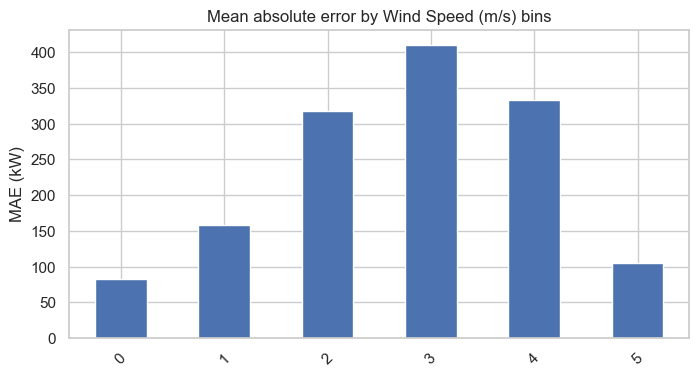

Linear vs MLP comparison:
{'t_stat': -8.229279554410878, 't_p': 2.1652036541213367e-16, 'wilcoxon_stat': 15413561.0, 'wilcoxon_p': 2.902635658719536e-25, 'mean_diff': -24.10366224368101}
{'obs_mean': -24.10366224368101, 'p_value': 0.4775, 'boot_means': array([-24.7232522 ,  -5.38139009, -25.95239313, ..., -34.12622018,
        -6.69511585,  -9.44112803])}


In [21]:
# ---------------------------
# Example usage (FIXED):
# ---------------------------

# Reset indices to ensure alignment
test_df_reset = X_test.copy().reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Make sure predictions are also properly aligned arrays
y_pred_lin_array = np.array(y_pred_lin)
y_pred_mlp_array = np.array(y_pred_mlp) 
y_pred_xgb_array = np.array(y_pred_xgb)

# Add actual values to test_df
test_df_reset['LV ActivePower (kW)'] = y_test_reset

preds = {
    "Linear": y_pred_lin_array,
    "MLP": y_pred_mlp_array,
    "XGBoost": y_pred_xgb_array
}

# Now run evaluation with reset indices
full_results_df, test_with_preds = evaluate_all_models(y_test_reset, preds, test_df=test_df_reset, block_size=24, n_boot=1000)
print(full_results_df)

# Plotting
best = min(preds.keys(), key=lambda k: compute_metrics(y_test_reset, preds[k])['MAE'])
plot_pred_vs_actual(y_test_reset, preds[best], title=f'Predicted vs Actual ({best})')
plt.show()

# Only plot time series if you have Date/Time column
if 'Date/Time' in test_with_preds.columns:
    plot_time_series_compare(test_with_preds['Date/Time'], y_test_reset, preds[best], n_show=2000)
    plt.show()

plot_residuals_hist(y_test_reset, preds[best])
plt.show()

plot_residuals_vs_pred(y_test_reset, preds[best])
plt.show()

plot_qq(y_test_reset, preds[best])
plt.show()

# Error-by-wind-speed (only if wind speed column exists)
if 'Wind Speed (m/s)' in test_with_preds.columns:
    ax, agg = plot_error_by_bin(test_with_preds, 'Wind Speed (m/s)', 'LV ActivePower (kW)', f'pred_{best}', bins=6)
    plt.show()

# Paired test example
print("Linear vs MLP comparison:")
print(paired_tests_time_series(y_test_reset, preds['Linear'], preds['MLP']))
print(block_bootstrap_pvalue(y_test_reset, preds['Linear'], preds['MLP'], block_size=24, n_boot=2000))

In [23]:
# Ablation study driver (time-series aware)
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings("ignore")

# ---------- Helper functions ----------
def make_features(df):
    """Create a full superset of engineered features (we will select subsets later)."""
    X = pd.DataFrame(index=df.index)
    X['WindSpeed'] = df['Wind Speed (m/s)']
    X['WindDir'] = df['Wind Direction (°)']
    X['PowerCurve'] = df['Theoretical_Power_Curve (KWh)']
    # cyclic
    X['WindDir_sin'] = np.sin(2*np.pi*X['WindDir']/360.0)
    X['WindDir_cos'] = np.cos(2*np.pi*X['WindDir']/360.0)
    # polynomial
    X['WindSpeed_sq'] = X['WindSpeed']**2
    X['WindSpeed_cu'] = X['WindSpeed']**3
    # time
    dt = pd.to_datetime(df['Date/Time'])
    X['Hour'] = dt.dt.hour
    X['DayOfWeek'] = dt.dt.dayofweek
    # lag / rolling (assumes regular sampling)
    X['Lag1_Power'] = df['LV ActivePower (kW)'].shift(1).fillna(method='bfill')
    X['RollMean_WS_1h'] = df['Wind Speed (m/s)'].rolling(window=6, min_periods=1).mean().fillna(method='bfill')
    return X

def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

def block_bootstrap_mae_ci(y_true, y_pred, block_size=24, n_boot=1000, alpha=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    blocks = [np.arange(i, min(n, i+block_size)) for i in range(0, n, block_size)]
    n_blocks = len(blocks)
    k = int(np.ceil(n / block_size))
    vals = []
    for _ in range(n_boot):
        chosen = rng.choice(n_blocks, size=k, replace=True)
        idx = np.concatenate([blocks[j] for j in chosen])[:n]
        vals.append(mean_absolute_error(y_true[idx], y_pred[idx]))
    vals = np.array(vals)
    lower = np.percentile(vals, 100*alpha/2.)
    upper = np.percentile(vals, 100*(1-alpha/2.))
    return mean_absolute_error(y_true, y_pred), lower, upper

# ---------- Baseline configuration (full pipeline) ----------
def build_pipeline(model_name='ridge', scaler=True, poly_degree=None):
    steps = []
    if scaler:
        steps.append(('scaler', StandardScaler()))
    if poly_degree is not None and poly_degree > 1:
        steps.append(('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)))
    if model_name == 'linear':
        steps.append(('model', LinearRegression()))
    elif model_name == 'ridge':
        steps.append(('model', Ridge(alpha=1.0)))
    elif model_name == 'rf':
        steps.append(('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)))
    elif model_name == 'mlp':
        steps.append(('model', MLPRegressor(hidden_layer_sizes=(64,32), max_iter=400, random_state=42)))
    else:
        raise ValueError("model_name unknown")
    return Pipeline(steps)

# ---------- Ablation configurations ----------
# Define a baseline feature set (full)
ALL_FEATURES = [
    'WindSpeed', 'PowerCurve', 'WindDir_sin', 'WindDir_cos',
    'WindSpeed_sq', 'WindSpeed_cu', 'Hour', 'DayOfWeek', 'Lag1_Power', 'RollMean_WS_1h'
]

ABLATIONS = [
    # remove one feature group at a time
    {'name': 'no_poly', 'features': [f for f in ALL_FEATURES if f not in ('WindSpeed_sq','WindSpeed_cu')], 'scaler': True, 'outlier_clip':True, 'model':'ridge'},
    {'name': 'no_winddir', 'features': [f for f in ALL_FEATURES if f not in ('WindDir_sin','WindDir_cos')], 'scaler': True, 'outlier_clip':True, 'model':'ridge'},
    {'name': 'no_temporal', 'features': [f for f in ALL_FEATURES if f not in ('Hour','DayOfWeek')], 'scaler': True, 'outlier_clip':True, 'model':'ridge'},
    {'name': 'no_lagrolling', 'features': [f for f in ALL_FEATURES if f not in ('Lag1_Power','RollMean_WS_1h')], 'scaler': True, 'outlier_clip':True, 'model':'ridge'},
    {'name': 'windspeed_only', 'features': ['WindSpeed'], 'scaler': True, 'outlier_clip':True, 'model':'ridge'},
    {'name': 'no_scaling', 'features': ALL_FEATURES, 'scaler': False, 'outlier_clip':True, 'model':'ridge'},
    {'name': 'no_outlier_clip', 'features': ALL_FEATURES, 'scaler': True, 'outlier_clip':False, 'model':'ridge'},
    # model ablations
    {'name': 'linear_model', 'features': ALL_FEATURES, 'scaler': True, 'outlier_clip':True, 'model':'linear'},
    {'name': 'rf_model', 'features': ALL_FEATURES, 'scaler': False, 'outlier_clip':True, 'model':'rf'},
    {'name': 'mlp_model', 'features': ALL_FEATURES, 'scaler': True, 'outlier_clip':True, 'model':'mlp'},
    # polynomial ridge vs baseline
    {'name': 'poly_deg2', 'features': ALL_FEATURES, 'scaler': True, 'outlier_clip':True, 'model':'ridge', 'poly':2},
]

# ---------- Data (replace with your df) ----------
# df must contain Date/Time, LV ActivePower (kW), Wind Speed (m/s), Wind Direction (°), Theoretical_Power_Curve (KWh)
# Example: df = pd.read_csv("my_scada.csv", parse_dates=['Date/Time'])
# For this script we will assume df is already loaded.

# ---------- Runner ----------
def run_ablation_study(df, target_col='LV ActivePower (kW)', date_col='Date/Time', block_size=24, n_boot=1000):
    df = df.copy().sort_values(date_col).reset_index(drop=True)
    X_full = make_features(df)
    y = df[target_col].values

    # Outlier clipping helper (IQR clipping)
    def clip_outliers(X, cols):
        Xc = X.copy()
        for c in cols:
            q1 = Xc[c].quantile(0.25)
            q3 = Xc[c].quantile(0.75)
            iqr = q3 - q1
            low = q1 - 1.5*iqr
            high = q3 + 1.5*iqr
            Xc[c] = Xc[c].clip(lower=low, upper=high)
        return Xc

    # Chronological split
    n = len(df)
    train_n = int(0.8 * n)
    X_train_full = X_full.iloc[:train_n].reset_index(drop=True)
    X_test_full  = X_full.iloc[train_n:].reset_index(drop=True)
    y_train = y[:train_n]
    y_test  = y[train_n:]

    results = []
    baseline_name = 'baseline'
    # Build baseline run (full features + ridge)
    baseline_cfg = {'name':'baseline','features':ALL_FEATURES,'scaler':True,'outlier_clip':True,'model':'ridge'}
    configs = [baseline_cfg] + ABLATIONS

    for cfg in configs:
        name = cfg['name']
        feats = cfg['features']
        scaler_flag = cfg.get('scaler', True)
        clip_flag = cfg.get('outlier_clip', True)
        model_type = cfg.get('model','ridge')
        poly_degree = cfg.get('poly', None)

        # Prepare X_train/X_test for this config
        X_tr = X_train_full[feats].copy()
        X_te = X_test_full[feats].copy()

        # Outlier clipping if requested
        if clip_flag:
            X_tr = clip_outliers(X_tr, X_tr.columns)
            # Apply same clipping bounds on test using train quantiles for fairness
            # (simple approach): compute bounds from train and clip test
            for c in X_tr.columns:
                q1 = X_train_full[c].quantile(0.25); q3 = X_train_full[c].quantile(0.75); iqr = q3-q1
                low = q1 - 1.5*iqr; high = q3 + 1.5*iqr
                X_te[c] = X_te[c].clip(lower=low, upper=high)

        # Build pipeline
        model_name = model_type
        pipe = build_pipeline(model_name=model_name, scaler=scaler_flag, poly_degree=poly_degree)

        # TimeSeries CV on training set
        tscv = TimeSeriesSplit(n_splits=5)
        cv_metrics = {'MAE':[], 'RMSE':[], 'R2':[]}
        X_tr_idx = X_tr.reset_index(drop=True)
        for train_idx, val_idx in tscv.split(X_tr_idx):
            X_tr_cv = X_tr_idx.iloc[train_idx]
            y_tr_cv = y_train[train_idx]
            X_val_cv = X_tr_idx.iloc[val_idx]
            y_val_cv = y_train[val_idx]

            pipe.fit(X_tr_cv, y_tr_cv)
            y_val_pred = pipe.predict(X_val_cv)
            m = eval_metrics(y_val_cv, y_val_pred)
            for k in cv_metrics:
                cv_metrics[k].append(m[k])

        cv_res = {k: np.mean(v) for k,v in cv_metrics.items()}

        # Final train on full train and evaluate on test
        pipe.fit(X_tr, y_train)
        y_test_pred = pipe.predict(X_te)
        test_res = eval_metrics(y_test, y_test_pred)

        # Bootstrap CI for test MAE
        mae_orig, mae_lower, mae_upper = block_bootstrap_mae_ci(y_test, y_test_pred, block_size=block_size, n_boot=n_boot)

        # Paired test vs baseline if baseline already computed
        if name == 'baseline':
            baseline_preds = y_test_pred.copy()
            paired_p = np.nan; wil_p = np.nan
        else:
            # Use baseline predictions computed earlier
            paired = None
            try:
                stat, paired_p = wilcoxon(np.abs(y_test - baseline_preds), np.abs(y_test - y_test_pred))
            except Exception:
                paired_p = np.nan
            wil_p = paired_p

        results.append({
            'config': name,
            'features': ','.join(feats[:5]) + ('...' if len(feats)>5 else ''),
            'cv_MAE': cv_res['MAE'],
            'cv_RMSE': cv_res['RMSE'],
            'cv_R2': cv_res['R2'],
            'test_MAE': test_res['MAE'],
            'test_RMSE': test_res['RMSE'],
            'test_R2': test_res['R2'],
            'MAE_CI_lower': mae_lower,
            'MAE_CI_upper': mae_upper,
            'wilcoxon_p_vs_baseline': wil_p
        })

        print(f"Done: {name} | test_MAE={test_res['MAE']:.2f} | test_R2={test_res['R2']:.4f}")

    results_df = pd.DataFrame(results)
    # Compute percent change vs baseline
    base_mae = results_df.loc[results_df['config']=='baseline','test_MAE'].values[0]
    results_df['delta_MAE_pct'] = (results_df['test_MAE'] - base_mae) / base_mae * 100.0

    return results_df

# ---------- Example usage ----------
results_df = run_ablation_study(df, target_col='LV ActivePower (kW)', date_col='Date/Time')
print(results_df.sort_values('test_MAE').to_string(index=False))


Done: baseline | test_MAE=118.87 | test_R2=0.9818
Done: no_poly | test_MAE=121.55 | test_R2=0.9817
Done: no_winddir | test_MAE=119.17 | test_R2=0.9817
Done: no_temporal | test_MAE=118.85 | test_R2=0.9818
Done: no_lagrolling | test_MAE=208.52 | test_R2=0.9098
Done: windspeed_only | test_MAE=409.99 | test_R2=0.8325
Done: no_scaling | test_MAE=118.89 | test_R2=0.9818
Done: no_outlier_clip | test_MAE=119.14 | test_R2=0.9819
Done: linear_model | test_MAE=118.89 | test_R2=0.9818
Done: rf_model | test_MAE=78.36 | test_R2=0.9875
Done: mlp_model | test_MAE=82.16 | test_R2=0.9901
Done: poly_deg2 | test_MAE=90.53 | test_R2=0.9882
         config                                                     features     cv_MAE    cv_RMSE    cv_R2   test_MAE  test_RMSE  test_R2  MAE_CI_lower  MAE_CI_upper  wilcoxon_p_vs_baseline  delta_MAE_pct
       rf_model WindSpeed,PowerCurve,WindDir_sin,WindDir_cos,WindSpeed_sq...  66.893228 147.298482 0.984975  78.364417 149.877157 0.987528     71.095487     86.225690 

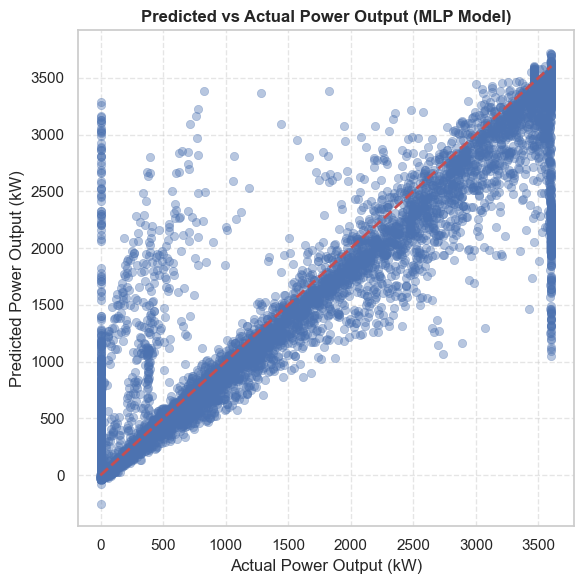

In [24]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Power Output (kW)')
plt.ylabel('Predicted Power Output (kW)')
plt.title('Predicted vs Actual Power Output (MLP Model)', weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
